In [85]:
!pip3 install nltk --user;
!pip3 install bs4;
!pip3 install scipy;
!pip3 install sklearn;
!pip3 install pandas;
!pip3 install requests;
!pip3 install nltk;
!pip3 install seaborn;

In [86]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage
import re
import numpy as np
from matplotlib import pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize


# sklearn imports
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF
from sklearn.cluster import DBSCAN
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import MeanShift
from sklearn.cluster import SpectralClustering
from sklearn.cluster import OPTICS
from sklearn.cluster import Birch
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import MiniBatchKMeans

# adaboost imports
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
# import cross_val_score
from sklearn.model_selection import cross_val_score

# LogisticRegression
from sklearn.linear_model import LogisticRegression

# Tree imports
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn import tree
from sklearn.tree import plot_tree
from sklearn.tree import export_text

from tqdm import tqdm
# from alive_progress import alive_bar

# import CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [87]:

def get_keywords(post):
    """Get the keywords from a post"""
    # Get the keywords from the post
    keywords = set()
    for word in re.split("\W+", post.text):
        if word in keywords:
            continue
        else:
            keywords.add(word)
    return keywords


# define the stop words list
stop_words = set(stopwords.words("english"))

# Remove Punctuation
def remove_punctuation(text):
    """Remove punctuation from a string"""
    return ''.join(ch for ch in text if ch not in stop_words)

# Lower Case
def lowercase(text):
    """Lower case a string"""
    return text.lower()



In [88]:
# opening the scraped data saved in csv files and creating a dataframe for each
df_ocd = pd.read_csv('../data/ocd_thread.csv')
df_autism = pd.read_csv('../data/autism_thread.csv')

# creating a target column for each dataframe
df_ocd['target'] = 1
df_autism['target'] = 0

# Cleaning up the data

In [89]:
# drop columns with more than 50% missing values from the dataframes
print(f'Dimensions before dropping columns with more than 50% missing values: {df_ocd.shape} for OCD and {df_autism.shape} for Autism')
df_ocd = df_ocd.dropna(thresh=0.5*len(df_ocd), axis=1)
df_autism = df_autism.dropna(thresh=0.5*len(df_autism), axis=1)
print(f'Dimensions after dropping columns with more than 50% missing values: {df_ocd.shape} for OCD and {df_autism.shape} for Autism')

Dimensions before dropping columns with more than 50% missing values: (41449, 93) for OCD and (25750, 90) for Autism
Dimensions after dropping columns with more than 50% missing values: (41449, 51) for OCD and (25750, 52) for Autism


In [90]:
print(f'columns in df_ocd: {df_ocd.columns}')


columns in df_ocd: Index(['author', 'author_flair_richtext', 'author_flair_type', 'can_mod_post',
       'contest_mode', 'created_utc', 'domain', 'full_link', 'id',
       'is_crosspostable', 'is_reddit_media_domain', 'is_self', 'is_video',
       'link_flair_richtext', 'link_flair_text_color', 'link_flair_type',
       'locked', 'num_comments', 'num_crossposts', 'over_18',
       'parent_whitelist_status', 'permalink', 'pinned', 'retrieved_on',
       'score', 'selftext', 'spoiler', 'stickied', 'subreddit', 'subreddit_id',
       'subreddit_type', 'thumbnail', 'title', 'url', 'whitelist_status',
       'send_replies', 'no_follow', 'subreddit_subscribers',
       'is_original_content', 'pwls', 'wls', 'media_only', 'is_meta',
       'author_fullname', 'gildings', 'is_robot_indexable',
       'author_patreon_flair', 'all_awardings', 'total_awards_received',
       'allow_live_comments', 'target'],
      dtype='object')


In [91]:
#* Only keep the columns in these two dataframes that are in both dataframes and are in the lists below
autism_columns_to_keep = ['author', 'author_flair_richtext', 'author_flair_type','created_utc', 'id', 'is_video', 'selftext', 'title', 'is_original_content','media_only', 'author_fullname','target']
ocd_columns_to_keep = ['author', 'author_flair_richtext', 'author_flair_type','created_utc', 'id', 'is_video', 'selftext', 'title', 'is_original_content','media_only', 'author_fullname','target']

In [92]:
# drop columns that are not in the lists above
print(f'Dimensions before dropping columns that are not in the lists above: {df_ocd.shape} for OCD and {df_autism.shape} for Autism')
df_ocd = df_ocd[ocd_columns_to_keep] 
df_autism = df_autism[autism_columns_to_keep]
print(f'Dimensions after dropping columns that are not in the lists above: {df_ocd.shape} for OCD and {df_autism.shape} for Autism')

Dimensions before dropping columns that are not in the lists above: (41449, 51) for OCD and (25750, 52) for Autism
Dimensions after dropping columns that are not in the lists above: (41449, 12) for OCD and (25750, 12) for Autism


In [93]:
# Now remove any posts from these dataframes where the `is_video` or `media_only` columsn are True
print(f'Dimensions before removing posts where `is_video` or `media_only` columns are True: {df_ocd.shape} for OCD and {df_autism.shape} for Autism')
df_ocd = df_ocd[(df_ocd['is_video'] == False) & (df_ocd['media_only'] == False)]
df_autism = df_autism[(df_autism['is_video'] == False) & (df_autism['media_only'] == False)]
print(f'Dimensions after removing posts where `is_video` or `media_only` columns are True: {df_ocd.shape} for OCD and {df_autism.shape} for Autism')

# and now we can drop the `is_video` and `media_only` columns
df_ocd = df_ocd.drop(columns=['is_video', 'media_only'])
df_autism = df_autism.drop(columns=['is_video', 'media_only'])
print(f'Dropped the `is_video` and `media_only` columns')


Dimensions before removing posts where `is_video` or `media_only` columns are True: (41449, 12) for OCD and (25750, 12) for Autism
Dimensions after removing posts where `is_video` or `media_only` columns are True: (37323, 12) for OCD and (25540, 12) for Autism
Dropped the `is_video` and `media_only` columns


In [94]:
# some posts are in the title column and some are in the selftext column so we need to combine these columns into one column if they are long enough.
# find the median length of the title and selftext columns combined for each dataframe
med_len_title_selftext_ocd = df_ocd.title.str.len().add(df_ocd.selftext.str.len()).median()
med_len_title_selftext_autism = df_autism.title.str.len().add(df_autism.selftext.str.len()).median()
print(f'Median length of title and selftext columns combined for OCD: {med_len_title_selftext_ocd}')
print(f'Median length of title and selftext columns combined for Autism: {med_len_title_selftext_autism}')


Median length of title and selftext columns combined for OCD: 652.0
Median length of title and selftext columns combined for Autism: 470.0


In [95]:
# how many posts have a title and selftext combined that are longer than the median length of the title and selftext columns combined for each dataframe?
print(f'Acceptable number of OCD posts: {len(df_ocd[df_ocd.title.str.len().add(df_ocd.selftext.str.len()) > med_len_title_selftext_ocd])}')
print(f'Acceptable number of Autism posts: {len(df_autism[df_autism.title.str.len().add(df_autism.selftext.str.len()) > med_len_title_selftext_autism])}')

Acceptable number of OCD posts: 16343
Acceptable number of Autism posts: 9021


In [96]:
# remove posts where the title and selftext combined are shorter than the median length of the title and selftext columns combined for each dataframe
print(f'Dimensions before: {df_ocd.shape} for OCD and {df_autism.shape} for Autism')
df_ocd = df_ocd[df_ocd.title.str.len().add(df_ocd.selftext.str.len()) > med_len_title_selftext_ocd]
df_autism = df_autism[df_autism.title.str.len().add(df_autism.selftext.str.len()) > med_len_title_selftext_autism]
print(f'Dimensions before: {df_ocd.shape} for OCD and {df_autism.shape} for Autism')

Dimensions before: (37323, 10) for OCD and (25540, 10) for Autism
Dimensions before: (16343, 10) for OCD and (9021, 10) for Autism


In [97]:
# drop author_flair_richtext
df_ocd = df_ocd.drop(columns=['author_flair_richtext'])
df_autism = df_autism.drop(columns=['author_flair_richtext'])


In [98]:
# how many authors are in each dataframe?
print(f'Number of authors in df_ocd: {len(df_ocd.author.unique())}')
print(f'Number of authors in df_autism: {len(df_autism.author.unique())}')


Number of authors in df_ocd: 7688
Number of authors in df_autism: 2897


In [100]:
# how many posts are there for the top 100 authors in each dataframe?
top_authors_ocd = df_ocd.author.value_counts().head(100)
top_authors_byfullname_ocd = df_ocd.author_fullname.value_counts().head(100)
top_authors_autism = df_autism.author.value_counts().head(100)
top_authors_byfullname_autism = df_autism.author_fullname.value_counts().head(100)

In [101]:
top_authors_ocd.head(2)

Userur      143
corinaah     44
Name: author, dtype: int64

In [102]:
top_authors_autism.head(2)

Jupiter642           47
anonaskingaccount    32
Name: author, dtype: int64

In [103]:
# are there any authors that are in both dataframes?
print(f'Number of authors that are in both dataframes: {len(set(top_authors_ocd.index).intersection(set(top_authors_autism.index)))}')
list_of_cross_posters = list(set(top_authors_ocd.index).intersection(set(top_authors_autism.index)))
print(f'List of authors that are in both dataframes: {list_of_cross_posters}')

Number of authors that are in both dataframes: 0
List of authors that are in both dataframes: []


In [104]:
# drop author_flair_type and author_fullname columns from both dataframes
df_ocd = df_ocd.drop(columns=['author_flair_type', 'author_fullname'])
df_autism = df_autism.drop(columns=['author_flair_type', 'author_fullname'])


In [105]:
# combine the title and self text columns into one column with the format `title - selftext`
df_ocd['title_selftext'] = df_ocd.title + ' - ' + df_ocd.selftext
df_autism['title_selftext'] = df_autism.title + ' - ' + df_autism.selftext


In [106]:
# drop the title and selftext columns
df_ocd = df_ocd.drop(columns=['title', 'selftext'])
df_autism = df_autism.drop(columns=['title', 'selftext'])


In [107]:
# rename the `title_selftext` column to `selftext`
df_ocd = df_ocd.rename(columns={'title_selftext': 'selftext'})
df_autism = df_autism.rename(columns={'title_selftext': 'selftext'})


In [108]:
# print the first five selftext posts for each dataframe


## cleaning out the post data (to remove biasing factors)

In [109]:
cancel_words = ['ocd','aut*','autism','obsess*','compuls*','disorder','diagnosis']

In [110]:
def censor_words(text):
    text = text.lower()
    # Remove all words that begin with 'aut' from the sentence and return the result
    # regex pattern
    pattern = r'aut(.*?)[^a-zA-Z]' # aut followed by any number of characters then ending in any character that is not a letter
    # replace those pattern matches with '' (nothing)
    text =  re.sub(pattern, '', text) # replace the pattern matches with '' (nothing)
    
    # pattern 2 - remove all words that begin with 'ocd' from the sentence and return the result
    pattern = r'ocd(.*?)[^a-zA-Z]' # ocd followed by any number of characters then ending in any character that is not a letter
    # replace those pattern matches with '' (nothing)
    text =  re.sub(pattern, '', text) # replace the pattern matches with '' (nothing)

    # pattern 3 - remove all words that begin with 'obsess' from the sentence and return the result
    pattern = r'obsess|compuls(.*?)[^a-zA-Z]' # obsess followed by any number of characters then ending in any character that is not a letter
    # replace those pattern matches with '' (nothing)
    text =  re.sub(pattern, '', text) # replace the pattern matches with '' (nothing)
    return text # return the result

# apply the censor_words function to the selftext column of each dataframe
df_ocd['selftext'] = df_ocd['selftext'].apply(censor_words)

# remove punctuation
df_ocd['selftext'] = df_ocd['selftext'].str.replace('[^\w\s]','')
# remove numbers
df_ocd['selftext'] = df_ocd['selftext'].str.replace('\d+', '')
# remove whitespace
df_ocd['selftext'] = df_ocd['selftext'].str.replace('\s+', ' ')

# do the same for the autism dataframe
df_autism['selftext'] = df_autism['selftext'].apply(censor_words)
# remove punctuation
df_autism['selftext'] = df_autism['selftext'].str.replace('[^\w\s]','')
# remove numbers
df_autism['selftext'] = df_autism['selftext'].str.replace('\d+', '')
# remove whitespace
df_autism['selftext'] = df_autism['selftext'].str.replace('\s+', ' ')



In [111]:
# remove words from posts that are in the cancel_words list. There are regex patterns in the cancel_words list so we need to use the `regex=True` parameter

# then remove double spaces
df_ocd['selftext'] = df_ocd['selftext'].str.replace('  ', ' ')
df_autism['selftext'] = df_autism['selftext'].str.replace('  ', ' ')

In [112]:
# make a new dataframe called df_reddit that combines the two dataframes

df_reddit = pd.DataFrame(columns=df_ocd.columns)
# what is the length of the shorter dataframe?
if len(df_ocd) < len(df_autism): # if the OCD dataframe is shorter
    shorter_df = df_ocd # set the shorter dataframe to the OCD dataframe
    longer_df = df_autism # set the longer dataframe to the Autism dataframe
    df_reddit.append()
else: # if the Autism dataframe is shorter
    shorter_df = df_autism
    longer_df = df_ocd

# add the shorter dataframe to the new dataframe using concat
df_reddit = pd.concat([df_reddit, shorter_df], axis=0)
# shorten the longer dataframe to the length of the shorter dataframe
longer_df = longer_df.head(len(shorter_df))
# add the shortened longer dataframe to the new dataframe using concat
df_reddit = pd.concat([df_reddit, longer_df], axis=0)

# reset the index
df_reddit = df_reddit.reset_index(drop=True)

In [113]:
# shuffle the dataframe
df_reddit = df_reddit.sample(frac=1).reset_index(drop=True)
# check the dimensions of the new dataframe
print(f'Dimensions of the new dataframe: {df_reddit.shape}')
df_reddit.head(5)

Dimensions of the new dataframe: (18042, 6)


,author,created_utc,id,is_original_content,target,selftext
0,supremeadhd,1617802337,mm25hg,False,1,always questioned if this is an ion so i have ...
1,victoriousJ4,1572077563,dnb0ck,False,1,can you ever overcome hey i do have for year n...
2,tuhsao,1538196542,9jtxaq,False,1,loves to get the last word in and its driving ...
3,lustforwine,1548271085,aj3bah,False,0,glitter hi everyone im undiagnosed atm but i j...
4,Gameperson700,1575163422,e47d28,False,0,whose else struggles with maladaptive daydream...


In [114]:
# double check that the number of posts for each subreddit is the same
print(f'Number of posts for OCD: {len(df_reddit[df_reddit.target == 1])}')
print(f'Number of posts for Autism: {len(df_reddit[df_reddit.target == 0])}')


Number of posts for OCD: 9021
Number of posts for Autism: 9021


# Post Cleaning Preview

In [223]:
df_ocd.head(2)

,author,created_utc,id,is_original_content,target,selftext
2016,mindkingdom,1527063603,8lhprn,False,1,thoughts that things could get corrupted or br...
2020,SteelSlayer7,1527074859,8lil9v,False,1,intrusive thoughts devaluing myself i am plagu...


In [224]:
df_autism.head(2)

,author,created_utc,id,is_original_content,target,selftext
0,Equadex,1546777579,ad56om,False,0,how can people be considered equals if they ar...
5,936R,1546786707,ad68am,False,0,questions for females with hi there im looking...


In [225]:
# find any of the medications in the selftext column that are in the data/drug_info.csv file under the Medication Name column and replace them with ' ' (empty string)
drug_info = pd.read_csv('../data/drug_info.csv')
drug_info['Medication Name'] = drug_info['Medication Name'].str.lower()


In [226]:
# create a list of the medications
medications = drug_info['Medication Name'].tolist()
print(f'Number of medications: {len(medications)}')

Number of medications: 3047


In [227]:
# how many posts contain a medication?
print(f'Number of posts that contain a medication: {len(df_reddit[df_reddit.selftext.str.contains("|".join(medications), regex=True)])}')

Number of posts that contain a medication: 18039


In [228]:
medications[0]

'abacavir sulfate'

In [229]:
# # is 'p' in the medications list?
# 'p' in medications
# # drop the 'p' from the medications list
# medications.remove('p')
# drop any medications that are less than 5 characters long
medications = [med for med in medications if len(med) > 5]

In [230]:
# create a list of rows and the medications mentioned in each row
import os
medications_mentioned = []
if os.path.exists('../data/cleaned_reddit.csv'):
    pass
else:
    # with alive_bar (len(df_reddit)) as bar:
    for index, row in df_reddit.iterrows(): # iterate through each row in the dataframe
        # use regex to find all of the medications in the selftext column
        meds = re.findall(r'\b(?:{})\b'.format('|'.join(medications)), row['selftext'])
        if len(meds) > 0: # if there are medications mentioned in the post
            # replace the medications with ' ' (empty string)
            row['selftext'] = re.sub(r'\b(?:{})\b'.format('|'.join(medications)), ' ', row['selftext'])
            medications_mentioned.extend(meds) # add the medications to the medications_mentioned list
            # remove duplicate medications
            medications_mentioned = list(set(medications_mentioned))
            # bar()

In [231]:
# remove the words from the selftext column that are in the medications list
# if the file does not already exist, create it
if os.path.exists('../data/cleaned_reddit.csv'):
    # load the file
    df_reddit = pd.read_csv('../data/cleaned_reddit.csv')
else:
    print('File does not exist. Creating it now. Before meds removed from selftext the length of the dataframe is: ', len(df_reddit))
    print(f' Removed {len(medications_mentioned)} medications from the selftext column')
    # save the dataframe to a csv file
    df_reddit.to_csv('../data/cleaned_reddit.csv', index=False)

In [232]:
# Now we want to clean the text in the self text column
# remove punctuation
df_reddit['selftext'] = df_reddit['selftext'].str.replace('[^\w\s]','')
# remove numbers
df_reddit['selftext'] = df_reddit['selftext'].str.replace('\d+', '')
# remove double spaces
df_reddit['selftext'] = df_reddit['selftext'].str.replace('  ', ' ')
# remove single characters
df_reddit['selftext'] = df_reddit['selftext'].str.replace(r'\b\w\b', '').str.replace(r'\s+', ' ')
# remove newlines
df_reddit['selftext'] = df_reddit['selftext'].str.replace(r'\n', ' ')
# remove urls
df_reddit['selftext'] = df_reddit['selftext'].str.replace(r'http\S+', '')
# remove html tags
df_reddit['selftext'] = df_reddit['selftext'].str.replace(r'<.*?>', '')
# remove extra spaces
df_reddit['selftext'] = df_reddit['selftext'].str.replace(r'\s+', ' ')
# remove extra spaces at the beginning of the string
df_reddit['selftext'] = df_reddit['selftext'].str.replace(r'^\s+', '')
# remove extra spaces at the end of the string
df_reddit['selftext'] = df_reddit['selftext'].str.replace(r'\s+$', '')

In [233]:
# read the file into a dataframe
df_reddit = pd.read_csv('../data/cleaned_reddit.csv')
# remove any rows that have a null value in the selftext column
df_reddit = df_reddit.dropna(subset=['selftext'])
# reset the index
df_reddit = df_reddit.reset_index(drop=True)
# check the dimensions of the dataframe
print(f'Dimensions of the dataframe: {df_reddit.shape}')
df_reddit.head(5)

Dimensions of the dataframe: (18042, 6)


,author,created_utc,id,is_original_content,target,selftext
0,ChubbyMonkeyX,1539241532,9n7o85,False,1,really bad but not very endangering ive though...
1,yognzvaidkd,1620336450,n6i6sp,False,1,a lot just happened and idk whats true can som...
2,kiranode,1554270592,b8u505,False,0,first group therapy session still stressed out...
3,b50142,1560436373,c06jok,False,0,participants needed support workers healthcare...
4,AccountForMyOCD,1558730325,bsly2g,False,1,just as i thought i was doing better i encount...


In [234]:
# Evaluate the model using cross validation
from sklearn.model_selection import cross_val_score

# import auc and roc_curve
from sklearn.metrics import auc, roc_curve

# suppress warnings
import warnings
warnings.filterwarnings('ignore')

import pickle

In [235]:
# for this next section we will refer to subreddits as targets
# rename the subreddit column to target in the df_reddit dataframe
df_reddit = df_reddit.rename(columns={'subreddit': 'target'})
# check the dimensions of the dataframe
print(f'Dimensions of the dataframe: {df_reddit.shape}')

Dimensions of the dataframe: (18042, 6)


In [236]:
# use count vectorizer to create a bag of words for the selftext column
from sklearn.feature_extraction.text import CountVectorizer

# create a count vectorizer object
count_vectorizer = CountVectorizer(stop_words='english', max_features=1000)

# fit and transform the count vectorizer on the selftext column
X = count_vectorizer.fit_transform(df_reddit['selftext']) # X is a sparse matrix
# convert to dense
X = X.todense() # X is now a dense matrix, which means it is no longer sparse and has no zeros
# convert to a dataframe and set the column names to the words in the count vectorizer
X = pd.DataFrame(X, columns=count_vectorizer.get_feature_names())
# check the dimensions of the dataframe
print(f'Dimensions of the dataframe: {X.shape}')
# X.head(5)
# Now we want to add the target column to the X dataframe so that we can use it to train the model
# add the target column to the X dataframe (the target column is the subreddit column from the df_reddit dataframe)
X['subreddit_target'] = df_reddit['target']
# check the dimensions of the dataframe
print(f'Dimensions of the dataframe: {X.shape}')


Dimensions of the dataframe: (18042, 1000)
Dimensions of the dataframe: (18042, 1001)


In [237]:
# import train_test_split
from sklearn.model_selection import train_test_split
# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X.drop('subreddit_target', axis=1), X['subreddit_target'], test_size=0.2, random_state=42)
# check the dimensions of the training and testing sets
print(f'Dimensions of the training set: {X_train.shape}')
print(f'Dimensions of the testing set: {X_test.shape}')


Dimensions of the training set: (14433, 1000)
Dimensions of the testing set: (3609, 1000)


In [238]:
# model results df
master_results_dataframe = pd.DataFrame(columns=['model', 'accuracy', 'precision', 'recall', 'f1', 'auc', 'cross_val_score', 'rmse', 'mae', 'r2','mse', 'time','train_score', 'test_score', 'best_params'])

In [ ]:
# create a dictionary of parameters for each model type

param_defaults = {
    'logistic_regression': {
        'penalty': ['l1', 'l2'],
        'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
    },
    'knn': {
        'n_neighbors': list(range(1, 31)),
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    },
    'random_forest': {
        'n_estimators': [10, 100, 1000],
        'max_depth': [3, 5, 10, None],
        'max_features': ['auto', 'sqrt', 'log2', None]
    },
    'svm': {
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
    },
    'decision_tree': {
        'max_depth': [3, 5, 10, None],
        'max_features': ['auto', 'sqrt', 'log2', None]
    },
    'gradient_boosting': {
        'n_estimators': [10, 100, 1000],
        'max_depth': [3, 5, 10, None],
        'max_features': ['auto', 'sqrt', 'log2', None]
    },
    'ada_boost': {
        'n_estimators': [10, 100, 1000],
        'learning_rate': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
    },
    'bagging': {
        'n_estimators': [10, 100, 1000],
        'max_samples': [0.5, 1.0],
        'max_features': [0.5, 1.0]
    },
    'extra_trees': {
        'n_estimators': [10, 100, 1000],
        'max_depth': [3, 5, 10, None],
        'max_features': ['auto', 'sqrt', 'log2', None]
    },
    'gaussian_nb': {
        'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
    },
    'bernoulli_nb': {
        'alpha': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
    },
    'multinomial_nb': {
        'alpha': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
    },
    'linear_svc': {
        'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
    },
    'xgboost': {
        'n_estimators': [10, 100, 1000],
        'max_depth': [3, 5, 10, None],
        'learning_rate': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
    }
}

In [239]:
# import the logistic regression model
from sklearn.linear_model import LogisticRegression
# import r2_score
from sklearn.metrics import r2_score
# import accuracy_score
from sklearn.metrics import accuracy_score
# import RMSE and MSE
from sklearn.metrics import mean_squared_error, mean_absolute_error
# import AUC and ROC
from sklearn.metrics import auc, roc_curve
# import recall_score, precision_score, f1_score
from sklearn.metrics import recall_score, precision_score, f1_score
# grid search
from sklearn.model_selection import GridSearchCV


In [240]:
def save_results(model,master_results_dataframe, y_test, y_pred, X_train, X_test, y_train):
    """
    save_results takes in a model and a master results dataframe and saves the model and the master results dataframe as a pickle file

    _extended_summary_

    :param model: _description_
    :type model: _type_
    :param master_results_dataframe: _description_
    :type master_results_dataframe: _type_
    :return: _description_
    :rtype: _type_
    """

    # evaluate the model
    acc_score = accuracy_score(y_test, y_pred) # accuracy score for the model on the testing set
    cross_val = cross_val_score(model, X_train, y_train, cv=5).mean()
    rmse = np.sqrt(mean_squared_error(y_test, y_pred)) # root mean squared error on the testing set
    mae = mean_absolute_error(y_test, y_pred) # on the testing set
    r2 = r2_score(y_test, y_pred) #
    mse = mean_squared_error(y_test, y_pred)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    auc_score = auc(fpr, tpr)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)


    print(f'accuracy_score: {acc_score}')
    print(f'cross_val_score: {cross_val}')
    print(f'rmse: {rmse}')
    print(f'mae: {mae}')
    print(f'r2: {r2}')
    print(f'mse: {mse}')
    print(f'auc: {auc_score}')
    print(f'false positive rate: {fpr}')
    print(f'true positive rate: {tpr}')
    print(f'thresholds: {thresholds}')

    # AUC and ROC
    # calculate the probabilities
    y_pred_prob = model.predict_proba(X_test)[:,1]
    # calculate the false positive rate and true positive rate
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    # calculate the area under the curve
    print(f'AUC score: {auc(fpr, tpr)}')


    #  train score
    train_score = model.score(X_train, y_train)
    # test score
    test_score = model.score(X_test, y_test)

    # perform grid search to find the best parameters
    # create a dictionary of parameters to search (for a logistic regression model)
    params = {
        'penalty': ['l1', 'l2'],
        'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
        'solver': ['liblinear', 'saga']
    }
    # create a grid search object
    grid_search = GridSearchCV(model, params, cv=5, verbose=1, n_jobs=-1)
    # fit the grid search object to the training data
    grid_search.fit(X_train, y_train)
    # get the best parameters
    best_params = grid_search.best_params_
    # get the best score
    best_score = grid_search.best_score_
    print(f'best parameters: {best_params}')
    print(f'best score: {best_score}')
    # best params
    best_params = model.best_params_
    # add the results to the master results dataframe using concat
    master_results_dataframe = pd.concat([master_results_dataframe, pd.DataFrame({'model': str(model), 'accuracy': acc_score, 'precision': precision, 'recall': recall, 'f1': f1, 'auc': auc_score, 'cross_val_score': cross_val, 'rmse': rmse, 'mae': mae, 'r2': r2, 'mse': mse}, index=[0])], ignore_index=True)
    # check the master results dataframe
    master_results_dataframe.head(5)

    # plot the ROC curve
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model} ROC Curve')
    # save the plot as a png file
    plt.savefig(f'../images/{model}_roc_curve.png')
    plt.show(); # the ROC curve is a plot of the true positive rate against the false positive rate
    return master_results_dataframe


#### Logistic Regression Model

In [244]:

# create a logistic regression model
logreg = LogisticRegression()

# fit the model on the training data
logreg.fit(X_train, y_train)

# predict on the testing data
y_pred = logreg.predict(X_test)

# evaluate the model
acc_score = accuracy_score(y_test, y_pred)
cross_val = cross_val_score(logreg, X_train, y_train, cv=5).mean()
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc_score = auc(fpr, tpr)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)


print(f'accuracy_score: {acc_score}')
print(f'cross_val_score: {cross_val}')
print(f'rmse: {rmse}')
print(f'mae: {mae}')
print(f'r2: {r2}')
print(f'mse: {mse}')
print(f'auc: {auc_score}')
print(f'false positive rate: {fpr}')
print(f'true positive rate: {tpr}')
print(f'thresholds: {thresholds}')

# AUC and ROC
# calculate the probabilities
y_pred_prob = logreg.predict_proba(X_test)[:,1]
# calculate the false positive rate and true positive rate
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
# calculate the area under the curve
print(f'AUC score: {auc(fpr, tpr)}')

# add the results to the master results dataframe using concat
master_results_dataframe = pd.concat([master_results_dataframe, pd.DataFrame({'model': 'logreg', 'accuracy': acc_score, 'precision': precision, 'recall': recall, 'f1': f1, 'auc': auc_score, 'cross_val_score': cross_val, 'rmse': rmse, 'mae': mae, 'r2': r2, 'mse': mse}, index=[0])], ignore_index=True)
# check the master results dataframe
master_results_dataframe.head(5)

accuracy_score: 0.9282349681352176
cross_val_score: 0.9292592477905952
rmse: 0.26788996223222417
mae: 0.07176503186478249
r2: 0.7125494880063277
mse: 0.07176503186478249
auc: 0.9287815540817727
false positive rate: [0.         0.05638665 1.        ]
true positive rate: [0.         0.91394976 1.        ]
thresholds: [2 1 0]
AUC score: 0.9760867679972742


,model,accuracy,precision,recall,f1,auc,cross_val_score,rmse,mae,r2,mse,time
0,logreg,0.928235,0.945796,0.913950,0.929600,0.928782,0.929259,0.267890,0.071765,0.712549,0.071765,NaN
1,AdaBoostClassifier(),0.887781,0.909040,0.870657,0.889435,0.888436,0.889073,0.334992,0.112219,0.550512,0.112219,NaN
2,logreg,0.928235,0.945796,0.913950,0.929600,0.928782,0.929259,0.267890,0.071765,0.712549,0.071765,NaN


#### Adaboost Model


accuracy_score: 0.8877805486284289
cross_val_score: 0.8890734650346704
rmse: 0.334991718362665
mae: 0.11221945137157108
r2: 0.5505117476546821
mse: 0.11221945137157108
auc: 0.888435720792005
false positive rate: [0.         0.09378596 1.        ]
true positive rate: [0.        0.8706574 1.       ]
thresholds: [2 1 0]
AUC score: 0.9596363304239685


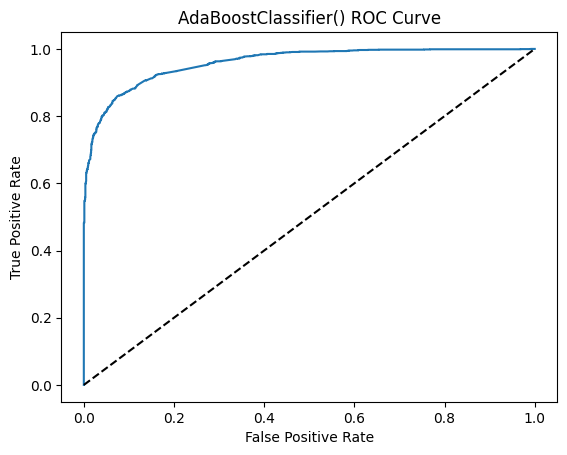

In [245]:

# import the AdaBoost classifier
from sklearn.ensemble import AdaBoostClassifier

# create an AdaBoost classifier
ada = AdaBoostClassifier()
model = ada
# fit the model on the training data
ada.fit(X_train, y_train)

# predict on the testing data
y_pred = ada.predict(X_test)

# 'y_test', 'y_pred', 'X_train', 'X_test', and 'y_train' are in the environment
master_results_dataframe = save_results(model,master_results_dataframe, y_test, y_pred, X_train, X_test, y_train)




accuracy_score: 0.8977556109725686
cross_val_score: 0.8974568290813529
rmse: 0.3197567654130737
mae: 0.10224438902743142
r2: 0.590466258974266
mse: 0.10224438902743142
auc: 0.8991810069383154
false positive rate: [0.         0.06214039 1.        ]
true positive rate: [0.         0.86050241 1.        ]
thresholds: [2 1 0]
AUC score: 0.9669103062367344


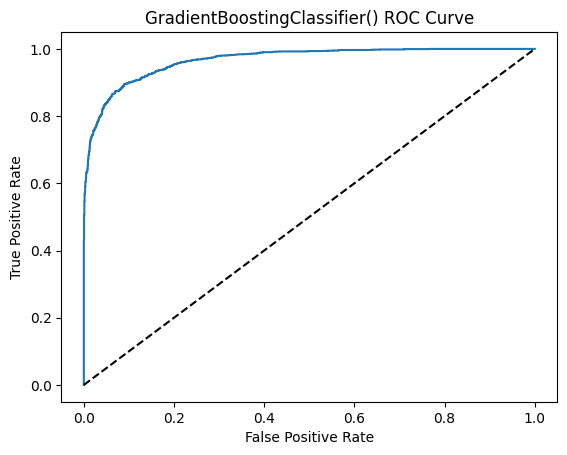

In [246]:

# import the Gradient Boosting classifier
from sklearn.ensemble import GradientBoostingClassifier

# create an AdaBoost classifier
gbc = GradientBoostingClassifier()
model = gbc
# fit the model on the training data
gbc.fit(X_train, y_train)

# predict on the testing data
y_pred = gbc.predict(X_test)


master_results_dataframe = save_results(model,master_results_dataframe, y_test, y_pred, X_train, X_test, y_train)



accuracy_score: 0.9686893876420061
cross_val_score: 0.9521927938969851
rmse: 0.17694804988468765
mae: 0.03131061235799391
r2: 0.874587228357973
mse: 0.03131061235799391
auc: 0.9691682878210761
false positive rate: [0.         0.01783659 1.        ]
true positive rate: [0.         0.95617317 1.        ]
thresholds: [2 1 0]
AUC score: 0.9963146542312898


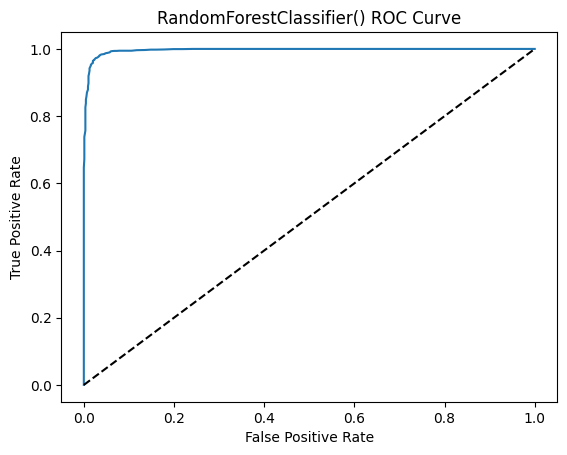

In [247]:
# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

# create a random forest classifier
rfc = RandomForestClassifier()
model = rfc
# fit the model on the training data
rfc.fit(X_train, y_train)

# predict on the testing data
y_pred = rfc.predict(X_test)

master_results_dataframe = save_results(model,master_results_dataframe, y_test, y_pred, X_train, X_test, y_train)

accuracy_score: 0.8805763369354391
cross_val_score: 0.8840159282140577
rmse: 0.34557728956712536
mae: 0.11942366306456081
r2: 0.5216557117016494
mse: 0.11942366306456081
auc: 0.882530526188896
false positive rate: [0.         0.06444189 1.        ]
true positive rate: [0.         0.82950294 1.        ]
thresholds: [2 1 0]
AUC score: 0.9423149900455071


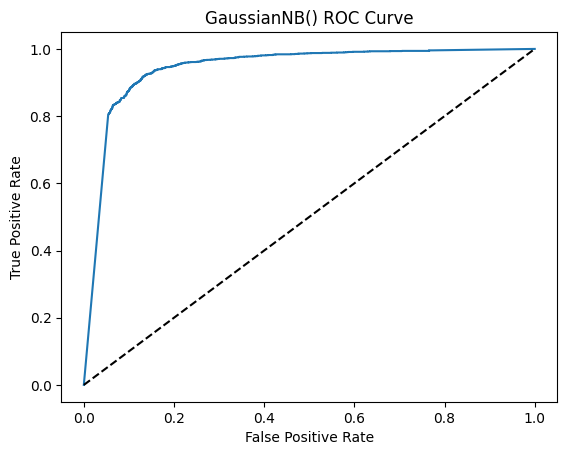

In [248]:
# Naive Bayes Classifier
from sklearn.naive_bayes import GaussianNB

# create a Gaussian Naive Bayes classifier
gnb = GaussianNB()

model = gnb

# fit the model on the training data
gnb.fit(X_train, y_train)

# predict on the testing data
y_pred = gnb.predict(X_test)

master_results_dataframe = save_results(model,master_results_dataframe, y_test, y_pred, X_train, X_test, y_train)

Fitting the model on the training data...
Predicting on the testing data...
Preparing The Results
accuracy_score: 0.6386810750900527
cross_val_score: 0.6636863556156941
rmse: 0.6010980992400053
mae: 0.3613189249099474
r2: -0.44724118779825806
mse: 0.3613189249099474
auc: 0.6436703632882486
false positive rate: [0.         0.22094361 1.        ]
true positive rate: [0.         0.50828434 1.        ]
thresholds: [2 1 0]
AUC score: 0.7134898908234767


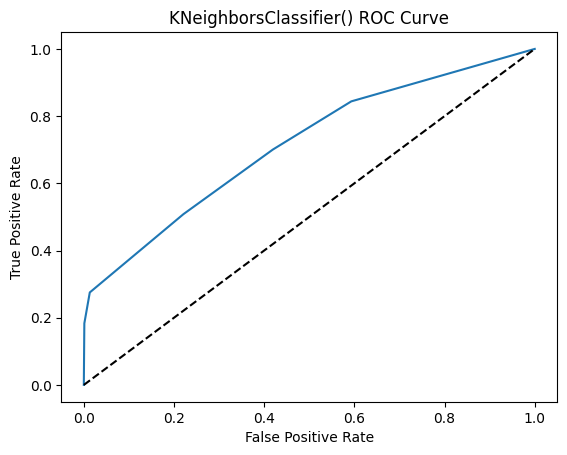

In [249]:
# K Nearest Neighbors Classifier
from sklearn.neighbors import KNeighborsClassifier

# create a K Nearest Neighbors classifier
knn = KNeighborsClassifier()

model = knn

print(f'Fitting the model on the training data...')
# fit the model on the training data
knn.fit(X_train, y_train)

print(f'Predicting on the testing data...')
# predict on the testing data
y_pred = knn.predict(X_test)

print(f'Preparing The Results')
master_results_dataframe = save_results(model,master_results_dataframe, y_test, y_pred, X_train, X_test, y_train)

Preparing The Results
accuracy_score: 0.9204765863119978
cross_val_score: 0.9063256536758442
rmse: 0.2819989604378041
mae: 0.07952341368800221
r2: 0.6814737569799847
mse: 0.07952341368800221
auc: 0.9222805352608003
false positive rate: [0.        0.0287687 1.       ]
true positive rate: [0.         0.87332977 1.        ]
thresholds: [2 1 0]
AUC score: 0.9222805352608003


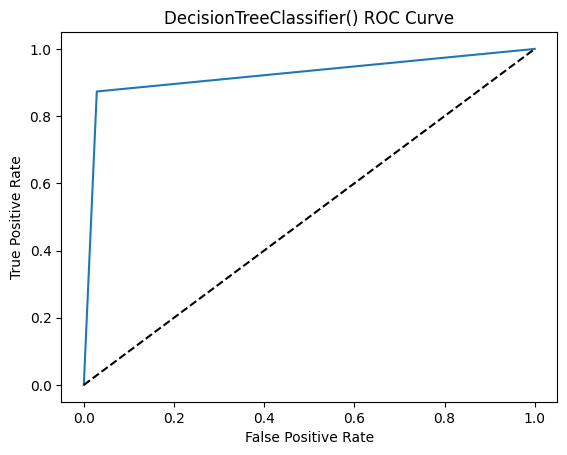

In [250]:
# Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier

# create a Decision Tree classifier
dtc = DecisionTreeClassifier()

model = dtc

# fit the model on the training data

dtc.fit(X_train, y_train)

# predict on the testing data

y_pred = dtc.predict(X_test)

print(f'Preparing The Results')
master_results_dataframe = save_results(model,master_results_dataframe, y_test, y_pred, X_train, X_test, y_train)

In [263]:
# drop the duplicated logreg model row
master_results_dataframe = master_results_dataframe.drop_duplicates(subset=['model'], keep='first')

In [264]:
master_results_dataframe.head(30)

,model,accuracy,precision,recall,f1,auc,cross_val_score,rmse,mae,r2,mse,time
0,logreg,0.928235,0.945796,0.913950,0.929600,0.928782,0.929259,0.267890,0.071765,0.712549,0.071765,NaN
1,AdaBoostClassifier(),0.887781,0.909040,0.870657,0.889435,0.888436,0.889073,0.334992,0.112219,0.550512,0.112219,NaN
4,GradientBoostingClassifier(),0.897756,0.937136,0.860502,0.897186,0.899181,0.897457,0.319757,0.102244,0.590466,0.102244,NaN
5,RandomForestClassifier(),0.968689,0.982967,0.956173,0.969385,0.969168,0.952193,0.176948,0.031311,0.874587,0.031311,NaN
6,GaussianNB(),0.880576,0.932692,0.829503,0.878076,0.882531,0.884016,0.345577,0.119424,0.521656,0.119424,NaN
7,KNeighborsClassifier(),0.638681,0.712360,0.508284,0.593263,0.643670,0.663686,0.601098,0.361319,-0.447241,0.361319,NaN
8,DecisionTreeClassifier(),0.920477,0.970309,0.873330,0.919269,0.922281,0.906326,0.281999,0.079523,0.681474,0.079523,NaN


In [252]:
master_results_dataframe.sort_values(by='accuracy', ascending=False)
# save to csv
master_results_dataframe.to_csv('../data/master_results_dataframe.csv', index=False)

In [260]:
print(f'The csv files generated here have the following sizes: \n X_df: {os.path.getsize("../data/X_df.csv")/1000000} MB \n y: {os.path.getsize("../data/y.csv")/1000000} MB')

The csv files generated here have the following sizes: 
 X_df: 36.092971 MB 
 y: 0.036091 MB


TFIDF Vectorizer

In [ ]:
# plot the results of the models as follows:
# a scatterplot with the x-axis being precision and the y-axis being recall
# the color represents the r2 score
# the size of the marker represents the cross_val_score
# the shape of the marker represents the model

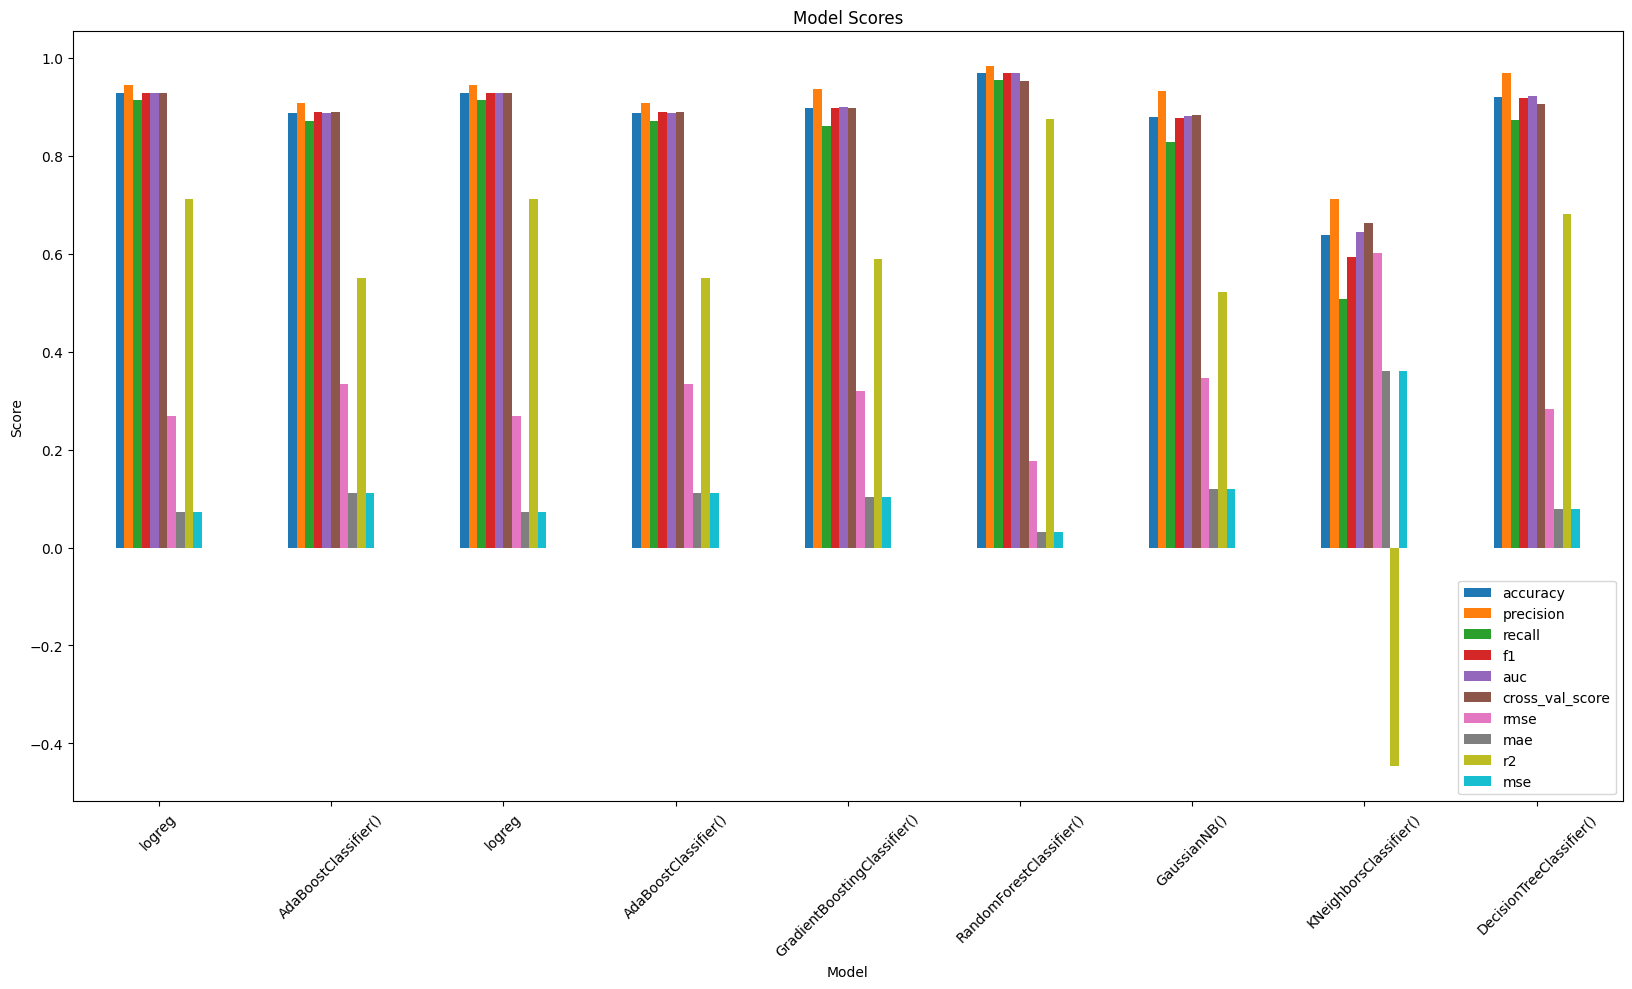

In [262]:




master_results_dataframe.plot.bar(x='model', y=['accuracy', 'precision', 'recall', 'f1', 'auc', 'cross_val_score', 'rmse', 'mae', 'r2', 'mse'], figsize=(20,10), title='Model Scores')

plt.title('Model Scores')
plt.xlabel('Model')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.savefig('../images/model_scores.png')
plt.show();
